In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
# 指定默认字体为黑体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
# # 设置正常显示符号
# plt.rcParams["axes.unicode_minus"] = False

In [2]:
tweet_file1_path = r'C:\Users\yst\Desktop\tweet\full_dataset-release.csv'
df = pd.read_csv(tweet_file1_path, low_memory=False,lineterminator="\n").head(2000)
df = df.iloc[:, 1:]
print(df.head())

                                               TWEET   STOCK        DATE  \
0  RT @robertoglezcano: @amazon  #Patents Show Fl...  Amazon  31/01/2017   
1  @FAME95FM1 Jamaicans make money with @Payoneer...  PayPal  31/01/2017   
2  @CBSi Jamaicans make money with @Payoneer @Pay...  PayPal  31/01/2017   
3  @Hitz92fm Jamaicans make money with @Payoneer ...  PayPal  31/01/2017   
4  RT @loadsofvans: Retweet this post &amp; follo...  Amazon  31/01/2017   

   LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  7_DAY_RETURN  \
0      823.48      0.008379      0.014924      0.014924     -0.001263   
1       39.78      0.002011      0.012318      0.012318      0.054801   
2       39.78      0.002011      0.012318      0.012318      0.054801   
3       39.78      0.002011      0.012318      0.012318      0.054801   
4      823.48      0.008379      0.014924      0.014924     -0.001263   

   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  TEXTBLOB_POLARITY  
0  3137196.0          1

In [3]:
# 筛选标称列
categorical_df = df.select_dtypes(include=['object', 'category'])
categorical_column = categorical_df.columns
# 给出各标称属性的频数
for name in categorical_column:
    # 输出标称属性的取值及对应频数（只显示前五行）
    print(categorical_df[name].value_counts().head())

TWEET
RT @trvo512: are you fucking kidding me? @McDonalds https://t.co/YgNCoLqJhr\r                                                                                               75
RT @nikitakhara: Thank you, @Starbucks CEO for committing to hire 10,000 refugees.\r\r\r\r\r\r\n\r\r\r\r\r\r\nTo all those tweeting #boycottstarbucks, thanks for the…\r    38
RT @MarkSimoneNY: Hey @Starbucks, instead of hiring 10,000 refugees, how about hiring 10,000 veterans.\r                                                                    33
RT @pepsi: We’ve got @LadyGaga’s #PepsiHalftime show under the 🔬 and it’s looking 🔥🔥🔥. Check out this #BehindTheScenes 📹 👆of h… \r                                          21
RT @Drops: yo fuck you @McDonalds https://t.co/NEUCDMBGMe\r                                                                                                                 20
Name: count, dtype: int64
STOCK
eBay          372
Starbucks     359
Reuters       302
Amazon        144
McDonald's    1

In [4]:
# 筛选数值列
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_column = numeric_df.columns
# 给出数值列的五数概括及缺失值个数
for name in numeric_column:
    # 输出五数概括
    print("列{0}的五数概括为:\n{1}".format(name, numeric_df[name].describe()))
    # 输出缺失值个数
    print("列{0}的缺失值个数为:{1}".format(name, numeric_df[name].isnull().sum()))

列LAST_PRICE的五数概括为:
count      2000.000000
mean        415.721912
std        4468.012298
min           4.210000
25%          49.080300
50%          55.220000
75%         122.570000
max      139500.000000
Name: LAST_PRICE, dtype: float64
列LAST_PRICE的缺失值个数为:0
列1_DAY_RETURN的五数概括为:
count    2000.000000
mean        0.005778
std         0.008535
min        -0.057476
25%        -0.000497
50%         0.006284
75%         0.010682
max         0.072391
Name: 1_DAY_RETURN, dtype: float64
列1_DAY_RETURN的缺失值个数为:0
列2_DAY_RETURN的五数概括为:
count    2000.000000
mean        0.011989
std         0.013718
min        -0.104513
25%         0.003122
50%         0.014924
75%         0.021363
max         0.082104
Name: 2_DAY_RETURN, dtype: float64
列2_DAY_RETURN的缺失值个数为:0
列3_DAY_RETURN的五数概括为:
count    2000.000000
mean        0.012563
std         0.013989
min        -0.104513
25%         0.003122
50%         0.014924
75%         0.021363
max         0.082104
Name: 3_DAY_RETURN, dtype: float64
列3_DAY_RETURN的缺失值个数为:0
列7

Font 'default' does not have a glyph for '\r' [U+d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\r' [U+d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\r' [U+d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\r' [U+d], substituting with a dummy symbol.


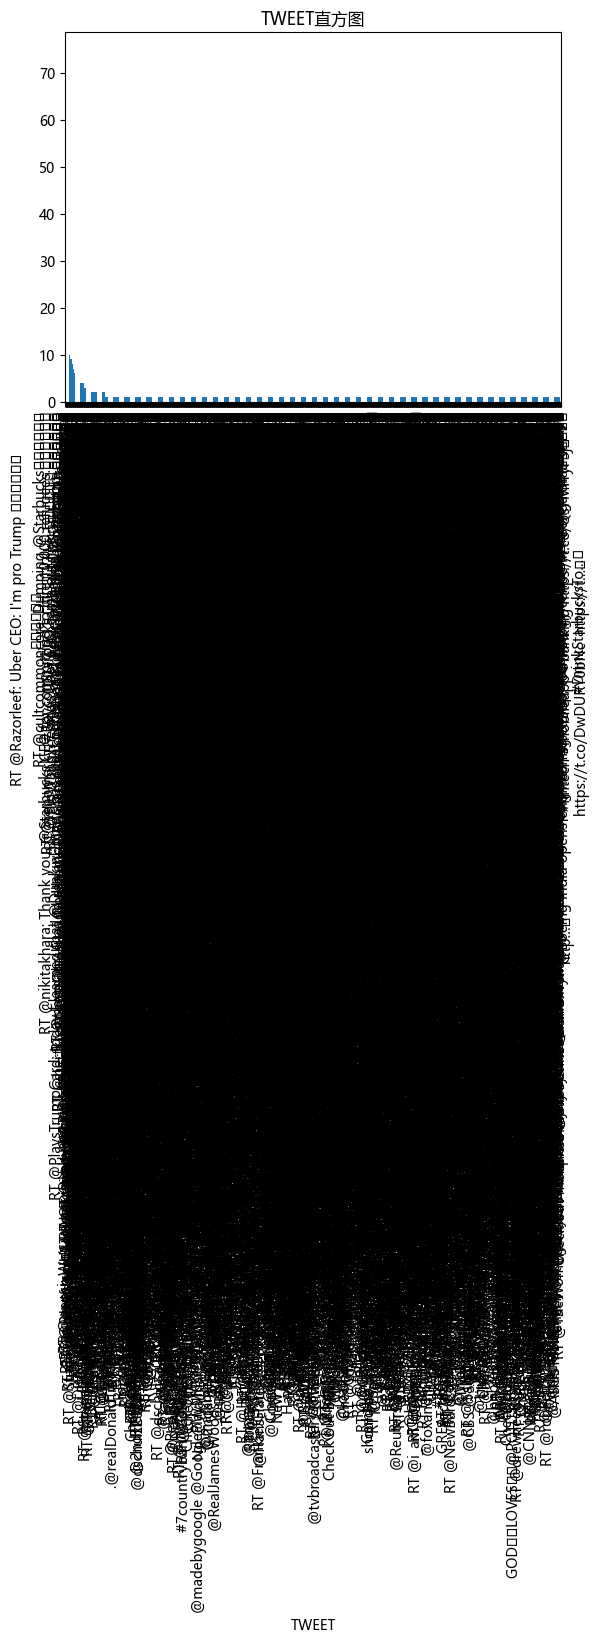

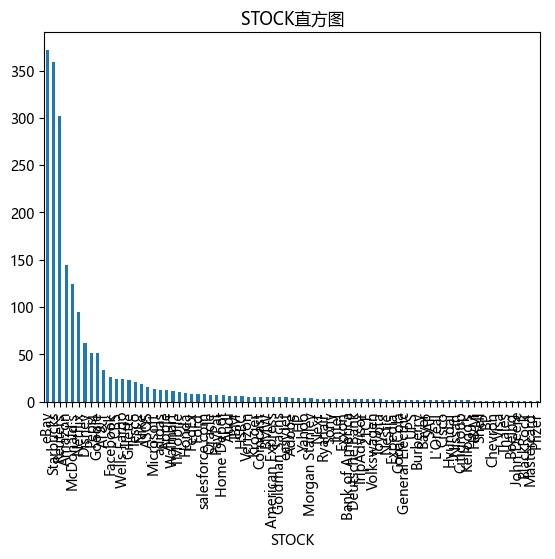

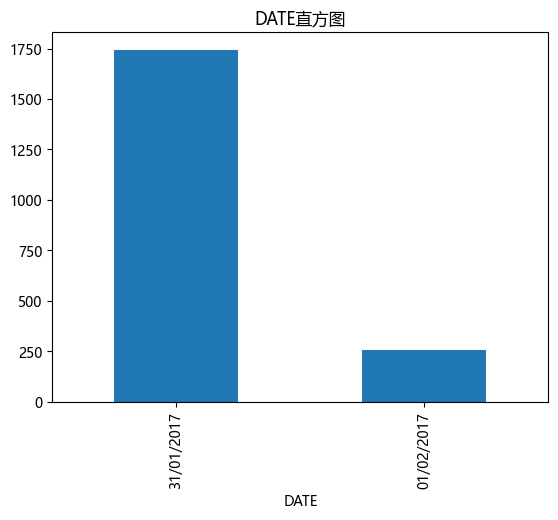

In [5]:
# 为标称列绘制直方图
for name in categorical_column:
    categorical_df[name].value_counts().plot(kind='bar')
    plt.title(str(name) + "直方图")
    plt.show()

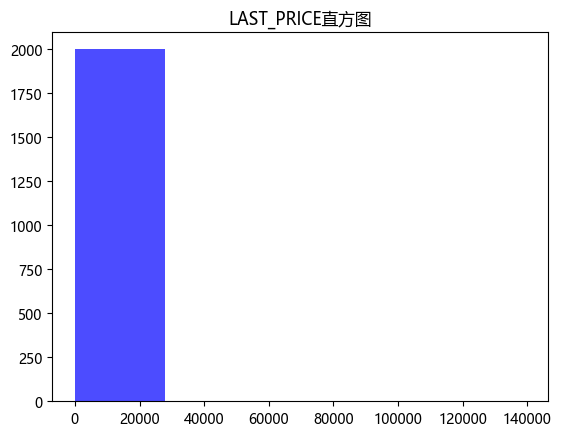

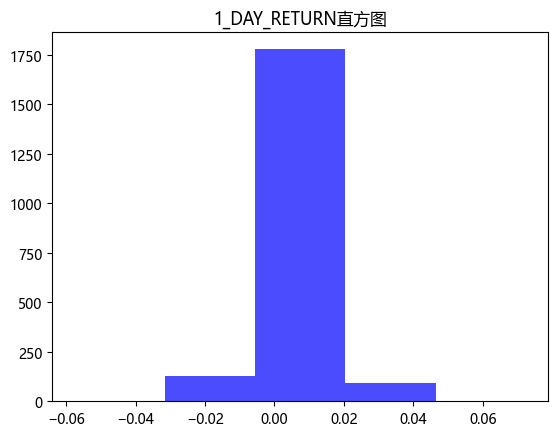

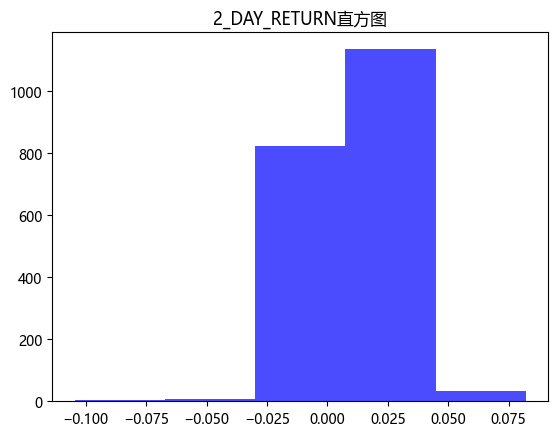

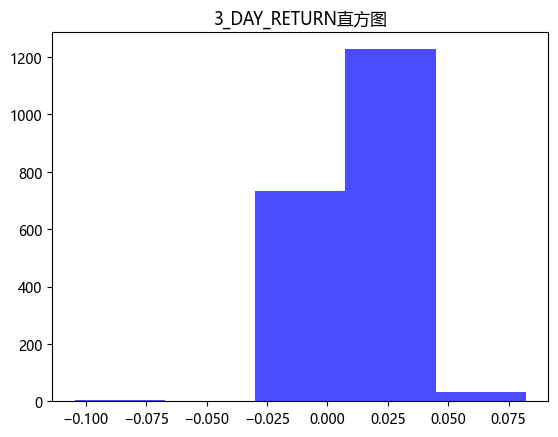

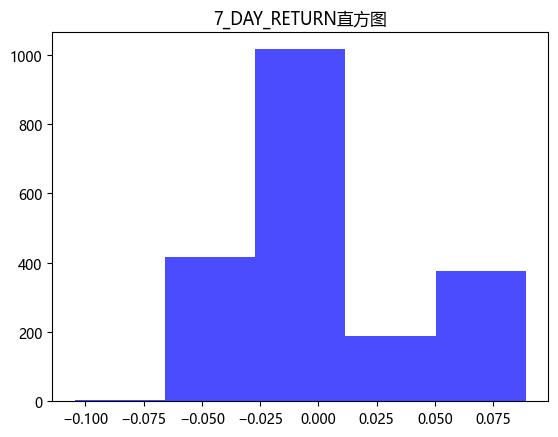

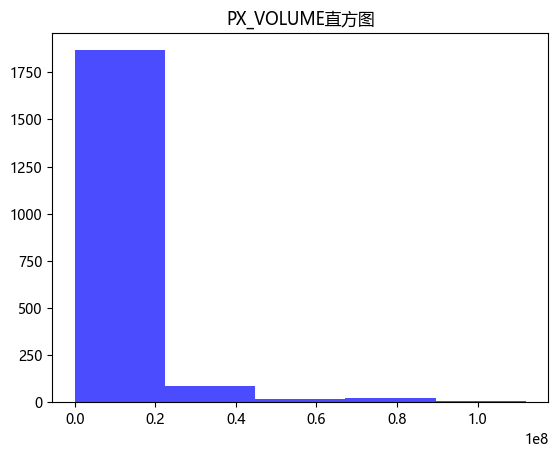

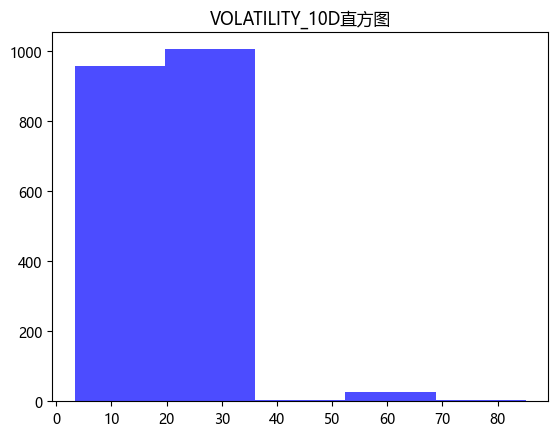

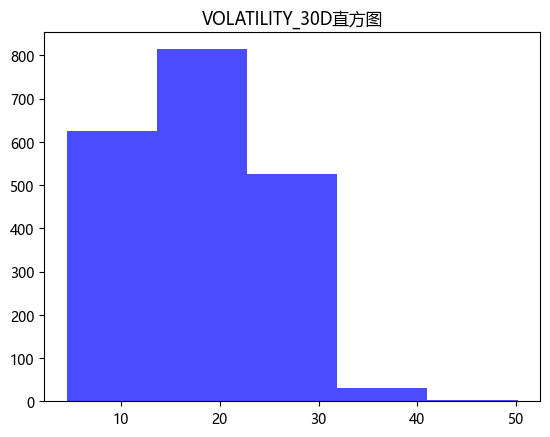

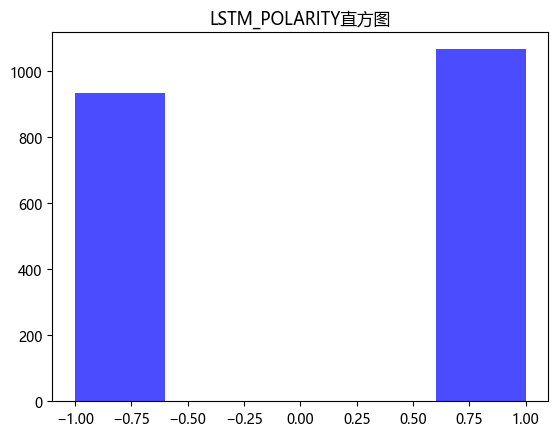

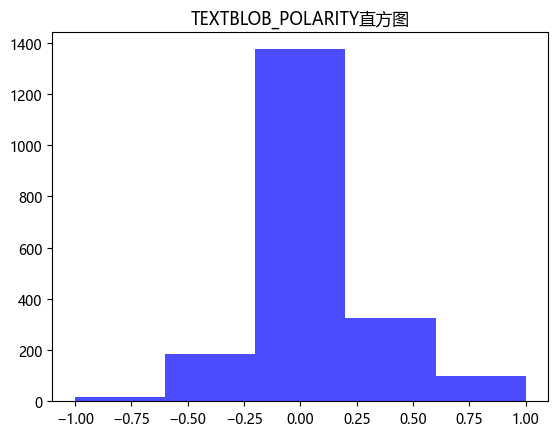

In [6]:
# 为数值列绘制直方图
for name in numeric_column:
    plt.hist(numeric_df[str(name)], bins=5, color='blue', alpha=0.7)
    plt.title(str(name) + "直方图")
    plt.show()

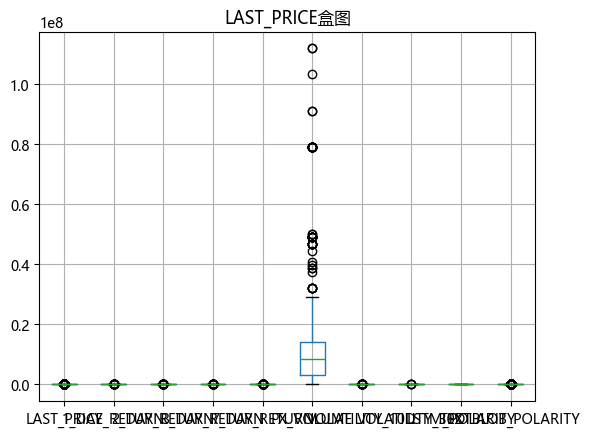

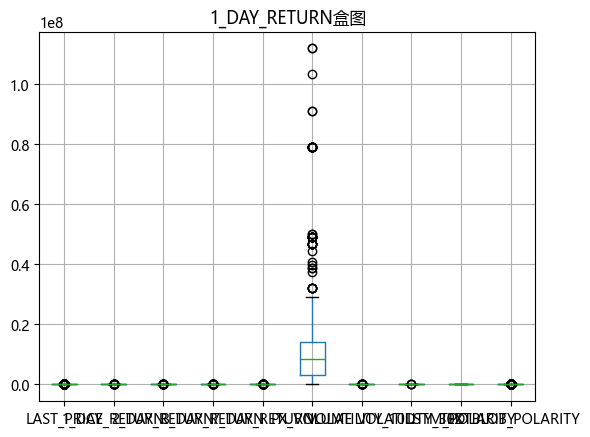

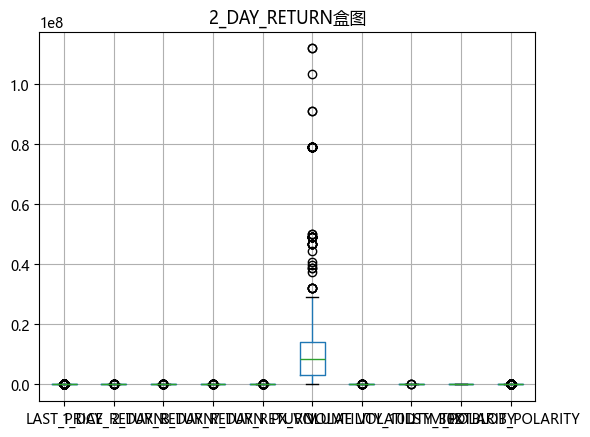

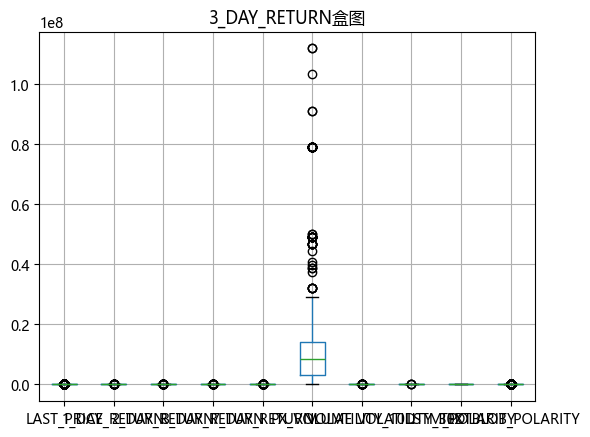

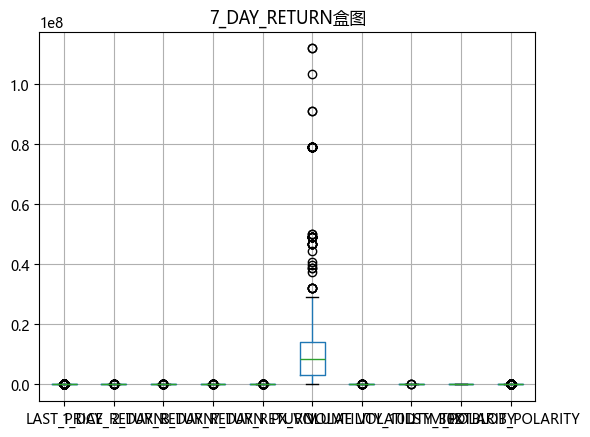

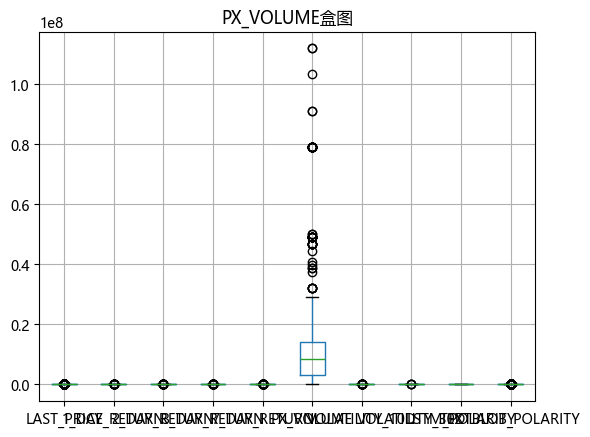

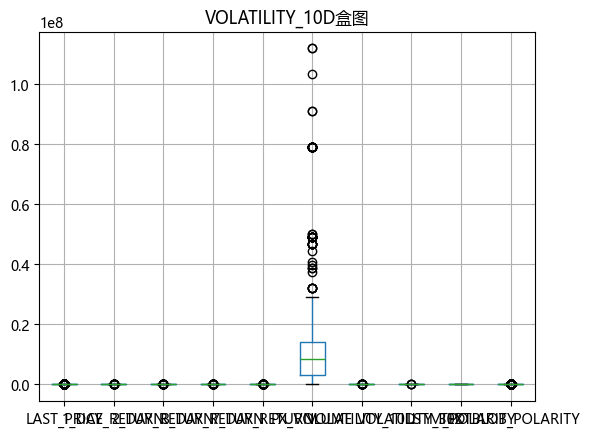

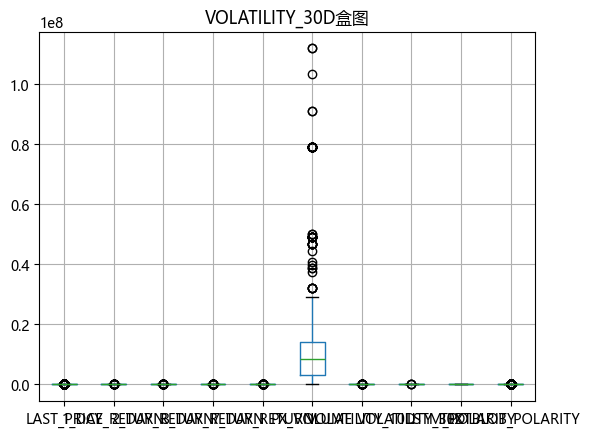

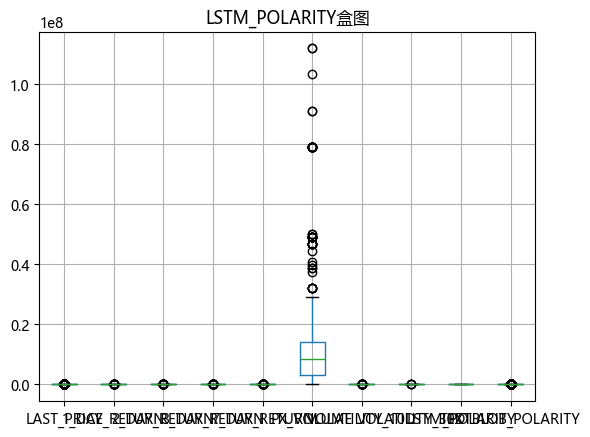

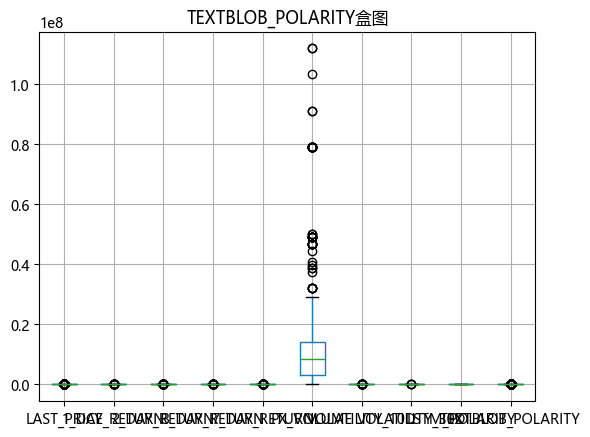

In [7]:
# 为数值列绘制盒图
for name in numeric_column:
    numeric_df.boxplot()
    plt.title(str(name) + "盒图")
    plt.show()

In [8]:
"""
创建数据处理副本
    df_cl_1：将缺失部分剔除
    df_cl_2：用最高频率值来填补缺失值
    df_cl_3：通过属性的相关关系来填补缺失值
    df_cl_4：通过数据对象之间的相似性来填补缺失值
"""

'\n创建数据处理副本\n    df_cl_1：将缺失部分剔除\n    df_cl_2：用最高频率值来填补缺失值\n    df_cl_3：通过属性的相关关系来填补缺失值\n    df_cl_4：通过数据对象之间的相似性来填补缺失值\n'

                                               TWEET   STOCK        DATE  \
0  RT @robertoglezcano: @amazon  #Patents Show Fl...  Amazon  31/01/2017   
1  @FAME95FM1 Jamaicans make money with @Payoneer...  PayPal  31/01/2017   
2  @CBSi Jamaicans make money with @Payoneer @Pay...  PayPal  31/01/2017   
3  @Hitz92fm Jamaicans make money with @Payoneer ...  PayPal  31/01/2017   
4  RT @loadsofvans: Retweet this post &amp; follo...  Amazon  31/01/2017   

   LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  7_DAY_RETURN  \
0      823.48      0.008379      0.014924      0.014924     -0.001263   
1       39.78      0.002011      0.012318      0.012318      0.054801   
2       39.78      0.002011      0.012318      0.012318      0.054801   
3       39.78      0.002011      0.012318      0.012318      0.054801   
4      823.48      0.008379      0.014924      0.014924     -0.001263   

   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  TEXTBLOB_POLARITY  
0  3137196.0          1

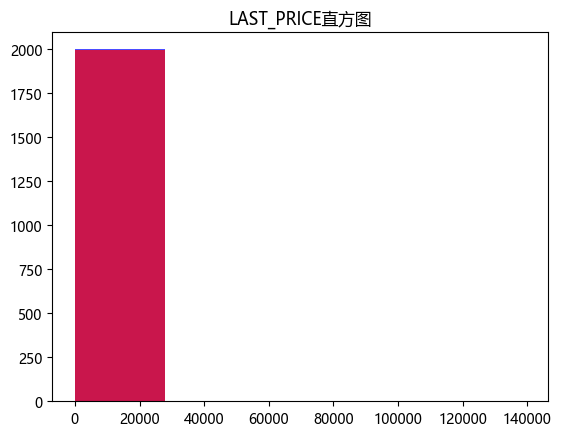

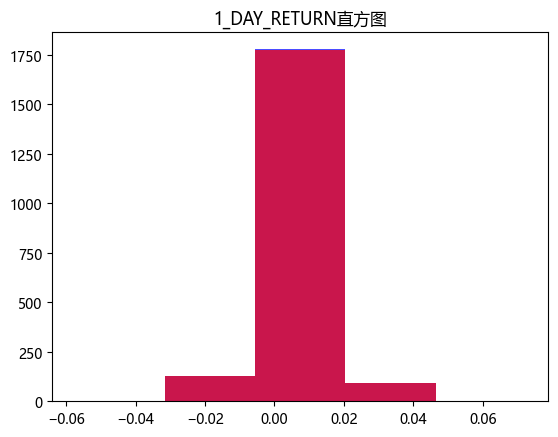

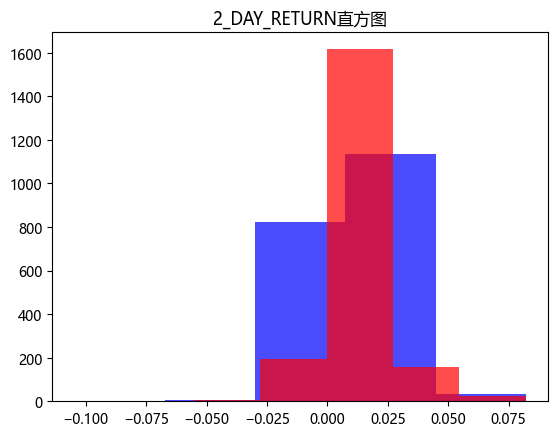

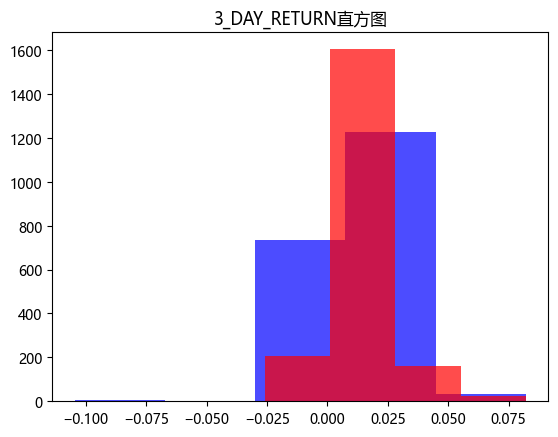

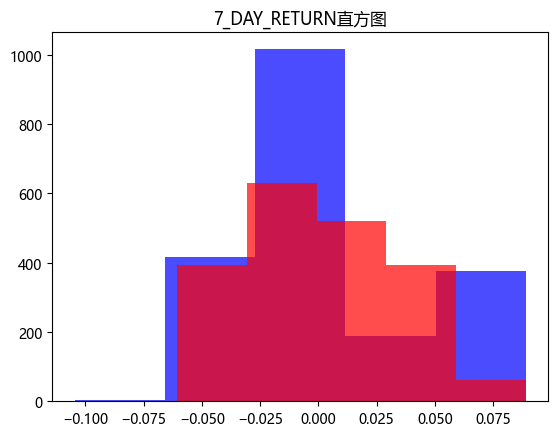

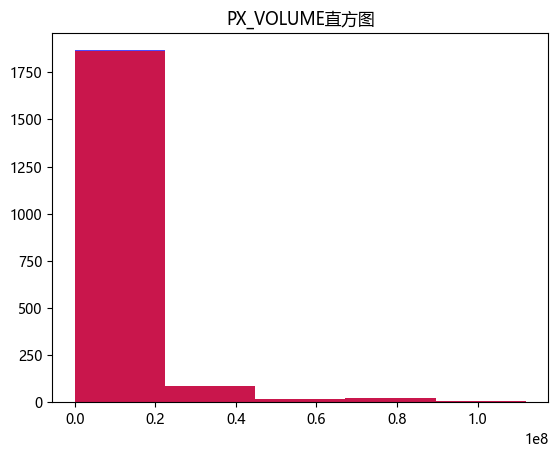

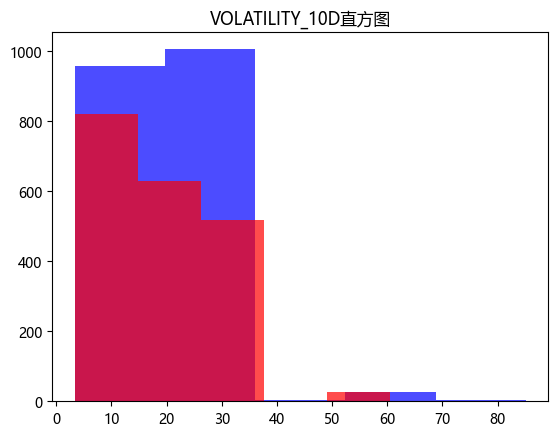

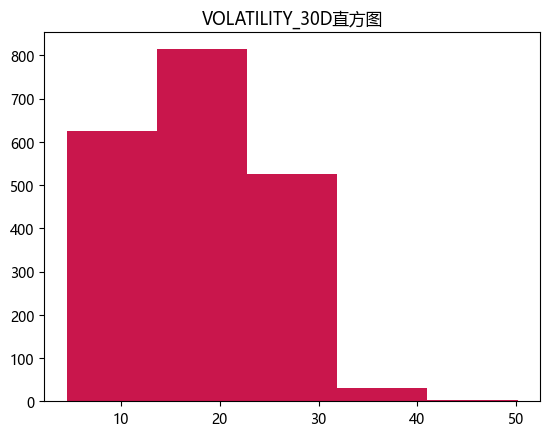

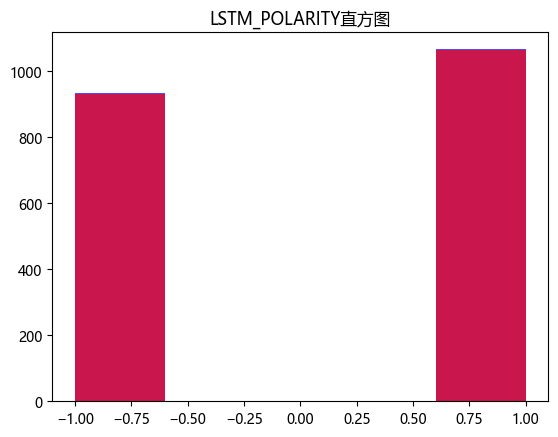

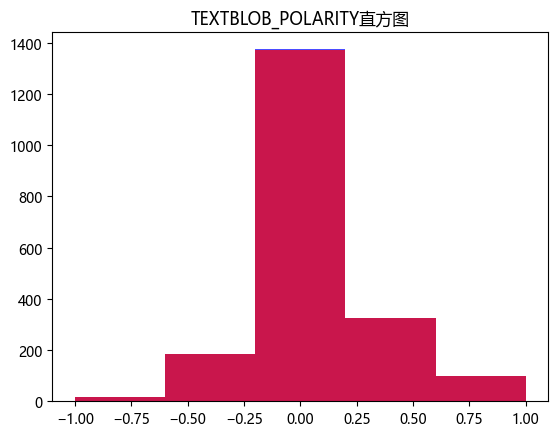

In [9]:
"""1、将缺失部分剔除"""
df_cl_1 = df.dropna()
print(df_cl_1.head())

"""对比"""
# 筛选数值列
numeric_df_1 = df_cl_1.select_dtypes(include=['int64', 'float64'])
numeric_column_1 = numeric_df_1.columns
# 给出数值列的五数概括及缺失值个数
for name in numeric_column:
    # 输出五数概括
    print("列{0}的补充前的五数概括为:\n{1}\n补充后的五数概括为:\n{2}".format(name, numeric_df[name].describe(), numeric_df_1[name].describe()))
    # 输出缺失值个数
    print("列{0}的缺失值个数为:{1}\n补充后的缺失值个数为{2}".format(name, numeric_df[name].isnull().sum(), numeric_df_1[name].isnull().sum()))
# 为数值列绘制直方图
for name in numeric_column:
    plt.hist(numeric_df[str(name)], bins=5, color='blue', alpha=0.7)
    plt.hist(numeric_df_1[str(name)], bins=5, color='red', alpha=0.7)
    plt.title(str(name) + "直方图")
    plt.show()

                                               TWEET   STOCK        DATE  \
0  RT @robertoglezcano: @amazon  #Patents Show Fl...  Amazon  31/01/2017   
1  @FAME95FM1 Jamaicans make money with @Payoneer...  PayPal  31/01/2017   
2  @CBSi Jamaicans make money with @Payoneer @Pay...  PayPal  31/01/2017   
3  @Hitz92fm Jamaicans make money with @Payoneer ...  PayPal  31/01/2017   
4  RT @loadsofvans: Retweet this post &amp; follo...  Amazon  31/01/2017   

   LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  7_DAY_RETURN  \
0      823.48      0.008379      0.014924      0.014924     -0.001263   
1       39.78      0.002011      0.012318      0.012318      0.054801   
2       39.78      0.002011      0.012318      0.012318      0.054801   
3       39.78      0.002011      0.012318      0.012318      0.054801   
4      823.48      0.008379      0.014924      0.014924     -0.001263   

   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  TEXTBLOB_POLARITY  
0  3137196.0          1

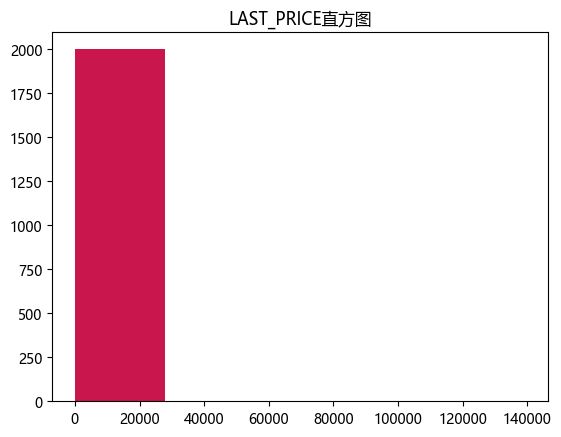

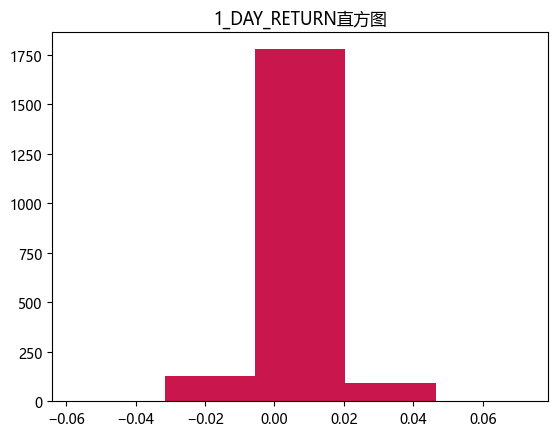

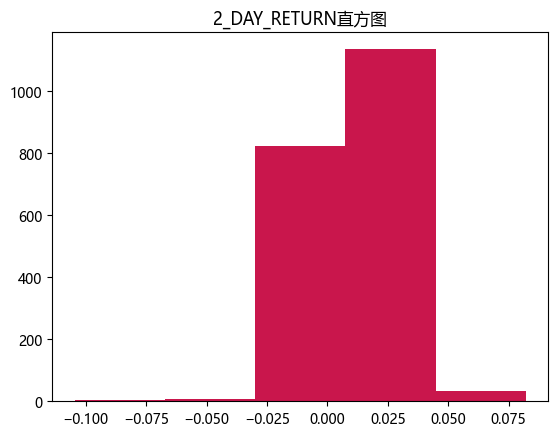

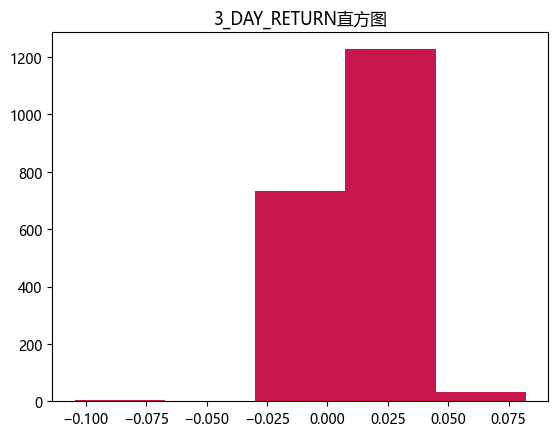

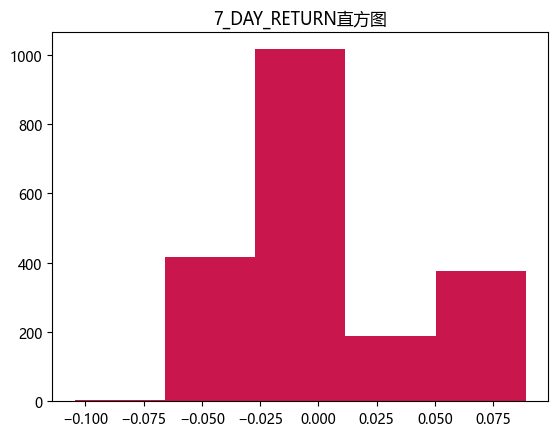

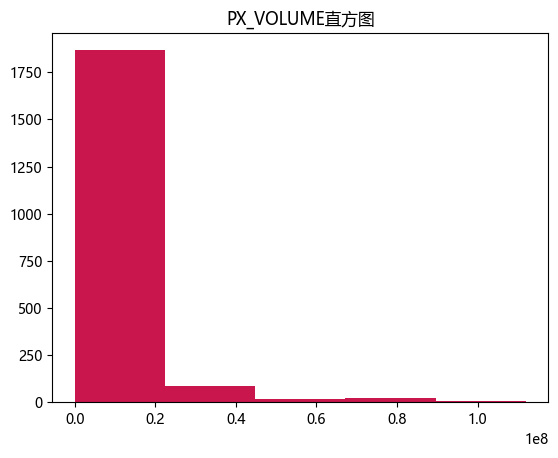

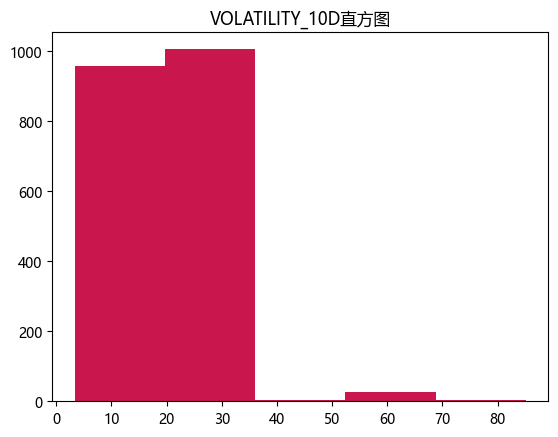

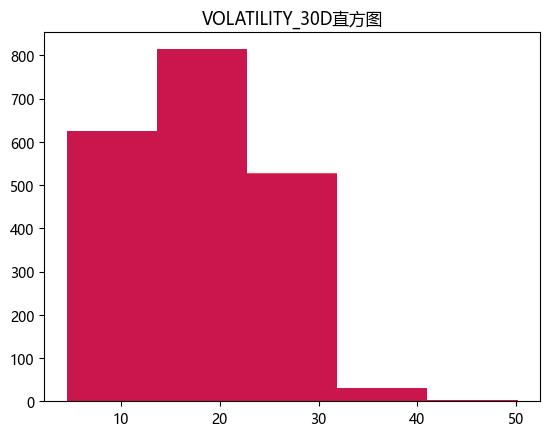

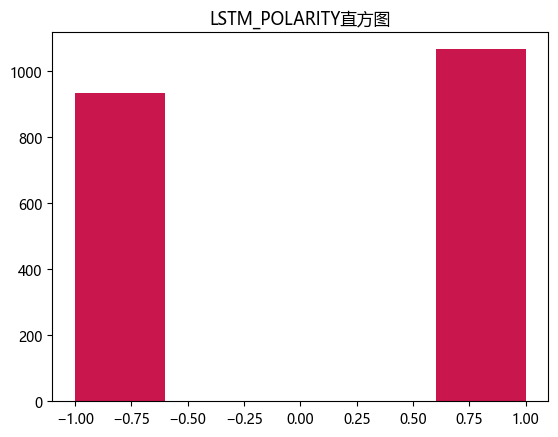

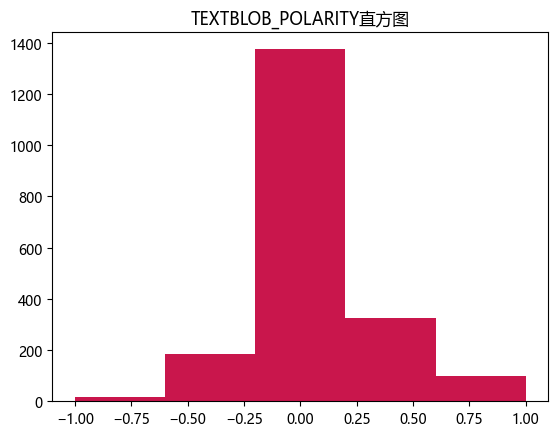

In [10]:
"""2、用最高频率值来填补缺失值"""
modes = df.mode().iloc[0] # 计算众数
df_cl_2 = df.fillna(modes)
print(df_cl_2.head())

"""对比"""
# 筛选数值列
numeric_df_2 = df_cl_2.select_dtypes(include=['int64', 'float64'])
numeric_column_2 = numeric_df_2.columns
# 给出数值列的五数概括及缺失值个数
for name in numeric_column:
    # 输出五数概括
    print("列{0}的补充前的五数概括为:\n{1}\n补充后的五数概括为:\n{2}".format(name, numeric_df[name].describe(), numeric_df_2[name].describe()))
    # 输出缺失值个数
    print("列{0}的缺失值个数为:{1}\n补充后的缺失值个数为{2}".format(name, numeric_df[name].isnull().sum(), numeric_df_2[name].isnull().sum()))
# 为数值列绘制直方图
for name in numeric_column:
    plt.hist(numeric_df[str(name)], bins=5, color='blue', alpha=0.7)
    plt.hist(numeric_df_2[str(name)], bins=5, color='red', alpha=0.7)
    plt.title(str(name) + "直方图")
    plt.show()

                                               TWEET   STOCK        DATE  \
0  RT @robertoglezcano: @amazon  #Patents Show Fl...  Amazon  31/01/2017   
1  @FAME95FM1 Jamaicans make money with @Payoneer...  PayPal  31/01/2017   
2  @CBSi Jamaicans make money with @Payoneer @Pay...  PayPal  31/01/2017   
3  @Hitz92fm Jamaicans make money with @Payoneer ...  PayPal  31/01/2017   
4  RT @loadsofvans: Retweet this post &amp; follo...  Amazon  31/01/2017   

   LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  7_DAY_RETURN  \
0      823.48      0.008379      0.014924      0.014924     -0.001263   
1       39.78      0.002011      0.012318      0.012318      0.054801   
2       39.78      0.002011      0.012318      0.012318      0.054801   
3       39.78      0.002011      0.012318      0.012318      0.054801   
4      823.48      0.008379      0.014924      0.014924     -0.001263   

   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  TEXTBLOB_POLARITY  
0  3137196.0          1

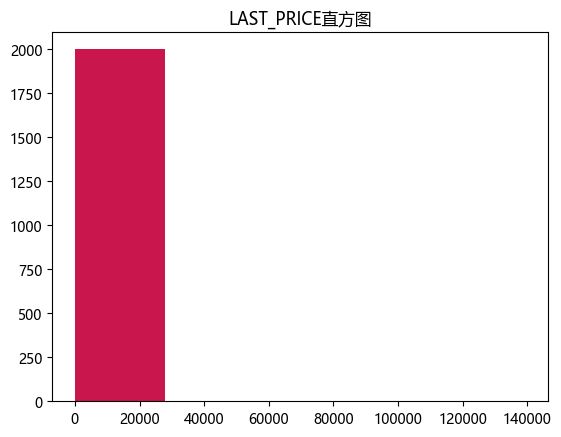

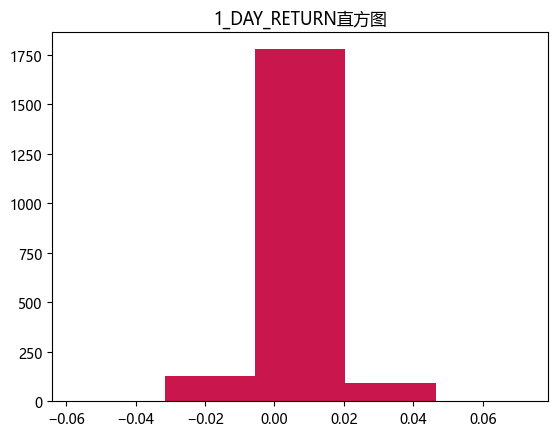

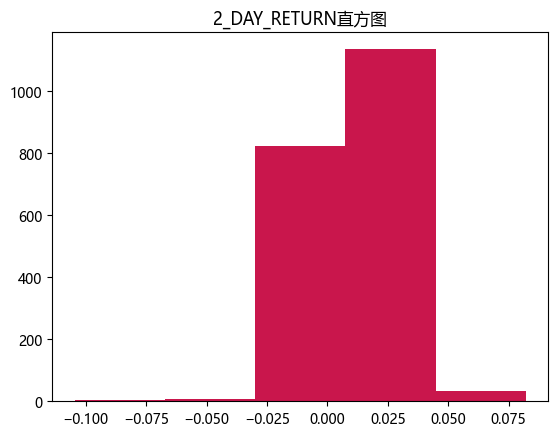

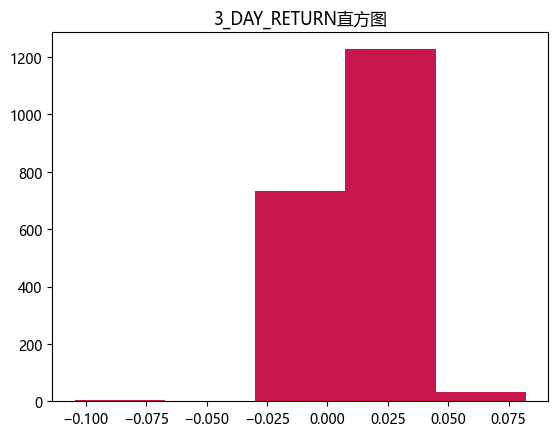

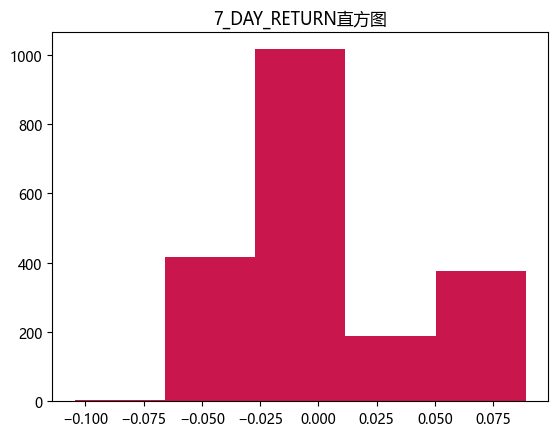

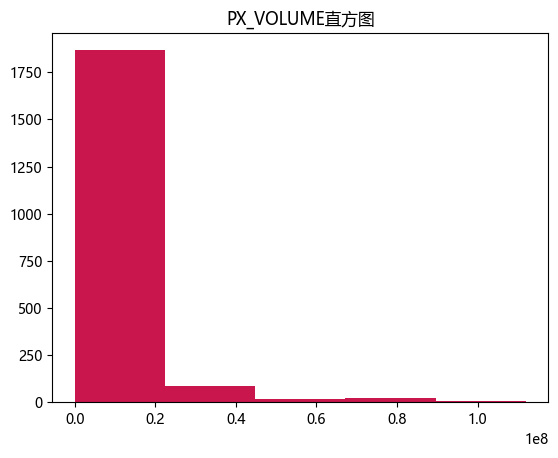

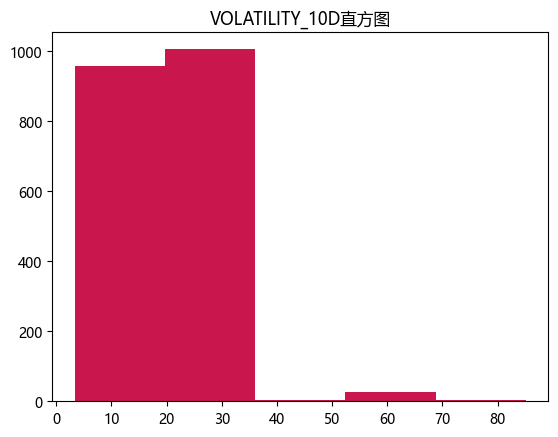

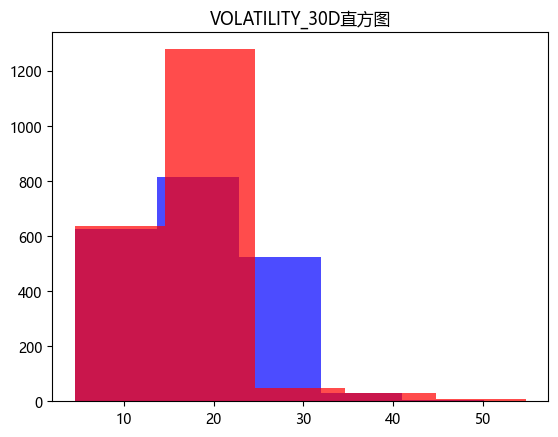

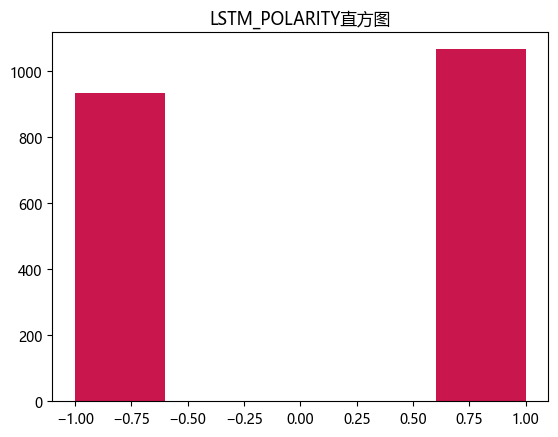

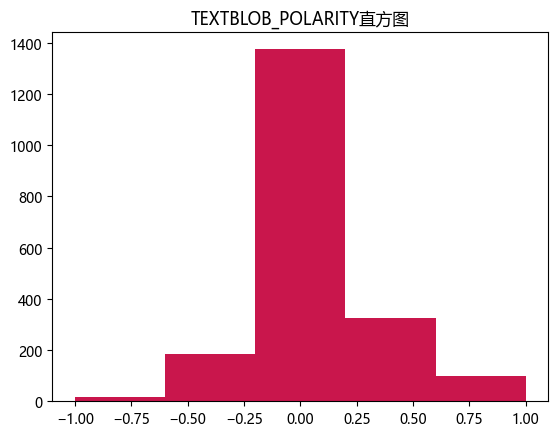

In [11]:
"""3、通过属性的相关关系来填补缺失值"""
df_cl_3 = df.copy(deep=True)
# 首先填补数值属性的缺失值
## 循环遍历数值属性列，利用其他数值属性列对缺失值进行预测（利用线性回归方法）
for name in numeric_column:
    # 划分标签数据和非标签数据
    df_labeled = df_cl_3.dropna()
    df_unlabeled = df_cl_3[df_cl_3[name].isna()]
    # 划分x，y
    X_labeled = df_labeled[[item for item in numeric_column if item != name]]
    y_labeled = df_labeled[name]
    model = LinearRegression().fit(X_labeled, y_labeled)
    # 对非标签值进行训练
    X_unlabeled = df_unlabeled[[item for item in numeric_column if item != name]]
    if X_unlabeled.shape[0] > 0:
        predicted_categories = model.predict(X_unlabeled)
        df_cl_3.loc[df_cl_3[name].isna(), name] = predicted_categories

# 然后填补标称属性的缺失值（默认数值属性填补成功）
## 循环遍历标称属性列，利用数值属性列对标称属性列的缺失值进行预测（利用随机森林算法）
for name in categorical_column:
    # 划分标签数据和非标签数据
    df_labeled = df_cl_3.dropna()
    df_unlabeled = df_cl_3[df_cl_3[name].isna()]
    # 划分x，y
    X_labeled = df_labeled[numeric_column]
    y_labeled = df_labeled[name]
    model = RandomForestClassifier()
    model.fit(X_labeled, y_labeled)
    # 对非标签值进行预测
    X_unlabeled = df_unlabeled[numeric_column]
    if X_unlabeled.shape[0] > 0:
        predicted_categories = model.predict(X_unlabeled)
        df_cl_3.loc[df_cl_3[name].isna(), name] = predicted_categories
print(df_cl_3.head())
"""对比"""
# 筛选数值列
numeric_df_3 = df_cl_3.select_dtypes(include=['int64', 'float64'])
numeric_column_3 = numeric_df_3.columns
# 给出数值列的五数概括及缺失值个数
for name in numeric_column:
    # 输出五数概括
    print("列{0}的补充前的五数概括为:\n{1}\n补充后的五数概括为:\n{2}".format(name, numeric_df[name].describe(), numeric_df_3[name].describe()))
    # 输出缺失值个数
    print("列{0}的缺失值个数为:{1}\n补充后的缺失值个数为{2}".format(name, numeric_df[name].isnull().sum(), numeric_df_3[name].isnull().sum()))
# 为数值列绘制直方图
for name in numeric_column:
    plt.hist(numeric_df[str(name)], bins=5, color='blue', alpha=0.7)
    plt.hist(numeric_df_3[str(name)], bins=5, color='red', alpha=0.7)
    plt.title(str(name) + "直方图")
    plt.show()

   LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  7_DAY_RETURN  \
0      823.48      0.008379      0.014924      0.014924     -0.001263   
1       39.78      0.002011      0.012318      0.012318      0.054801   
2       39.78      0.002011      0.012318      0.012318      0.054801   
3       39.78      0.002011      0.012318      0.012318      0.054801   
4      823.48      0.008379      0.014924      0.014924     -0.001263   

   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  \
0  3137196.0          13.447          16.992            1.0   
1  9100057.0          18.769          16.099           -1.0   
2  9100057.0          18.769          16.099            1.0   
3  9100057.0          18.769          16.099           -1.0   
4  3137196.0          13.447          16.992           -1.0   

   TEXTBLOB_POLARITY                                              TWEET  \
0                0.0  RT @robertoglezcano: @amazon  #Patents Show Fl...   
1                0.0  @FAME95FM1

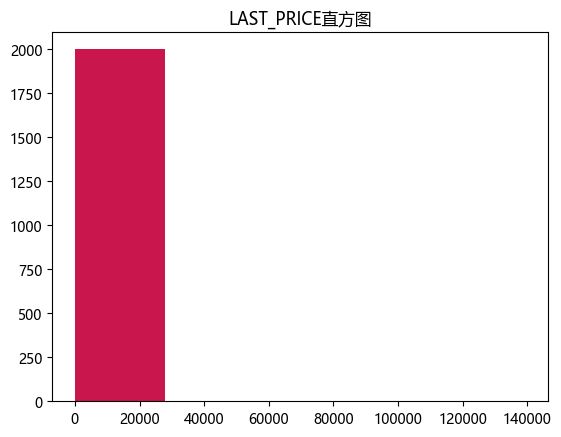

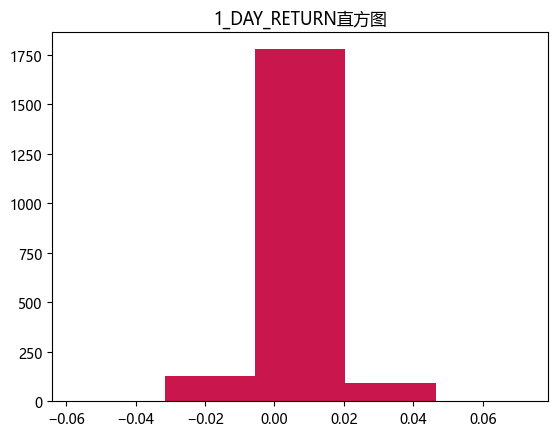

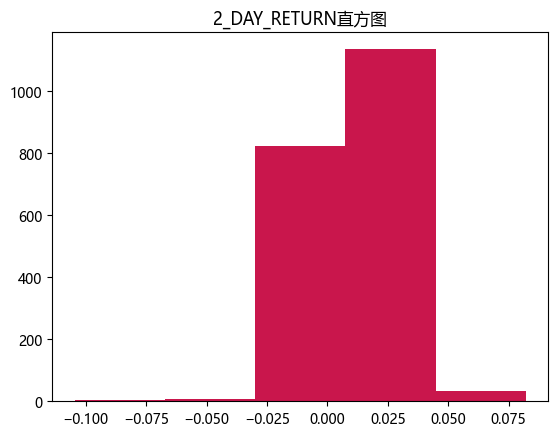

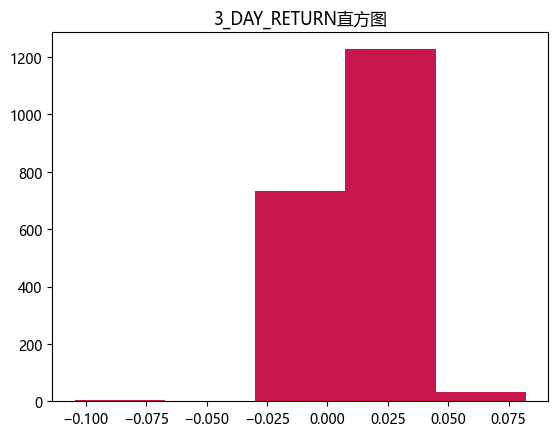

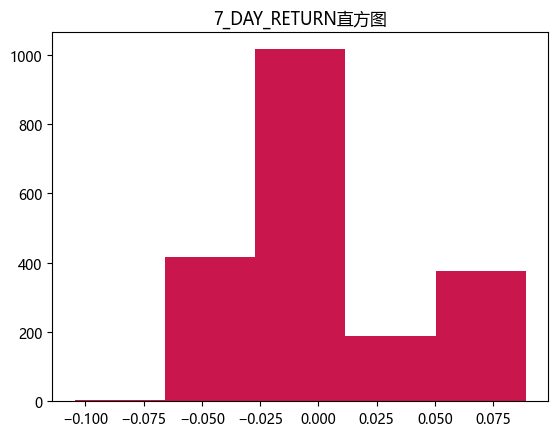

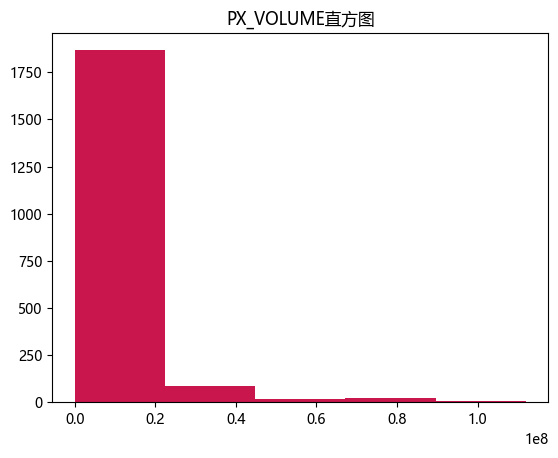

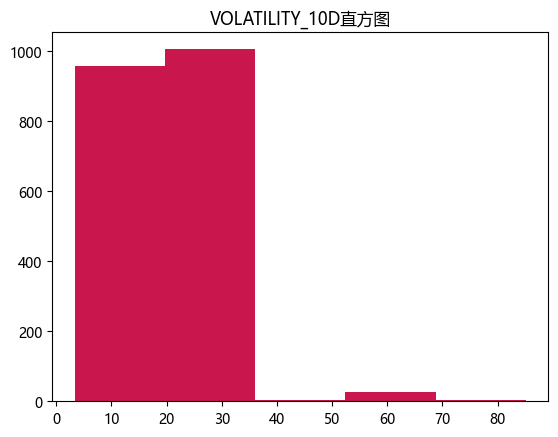

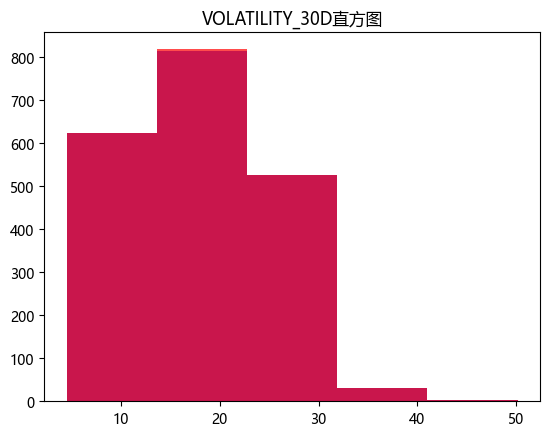

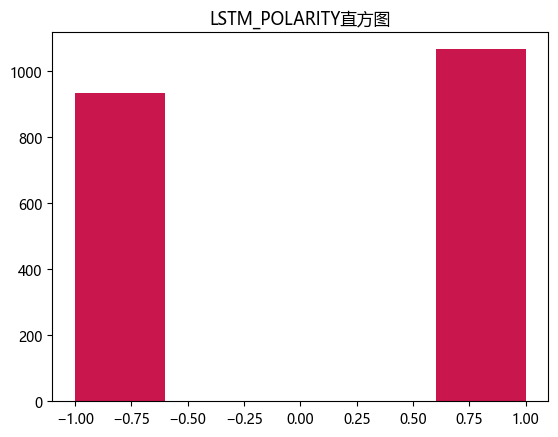

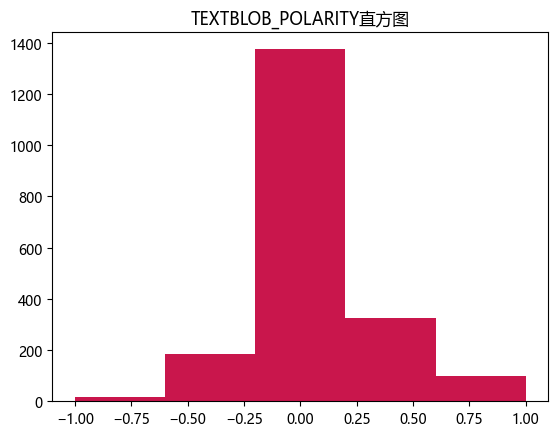

In [12]:
def undummify(df, prefix_sep="_"): # 独热编码的逆向操作
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

"""4、通过数据对象之间的相似性来填补缺失值（尝试使用k-最近邻（k-NN）算法估计对象相似性并填补缺失值）"""
df_encoded = pd.get_dummies(df, columns=categorical_column, prefix_sep=':') 
imputer = KNNImputer(n_neighbors=2) # 创建KNNImputer实例，n_neighbors是k-最近邻算法中的k值
df_cl_4 = undummify(pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns), ':')
print(df_cl_4.head())

"""对比"""
# 筛选数值列
numeric_df_4 = df_cl_4.select_dtypes(include=['int64', 'float64'])
numeric_column_4 = numeric_df_4.columns
# 给出数值列的五数概括及缺失值个数
for name in numeric_column:
    # 输出五数概括
    print("列{0}的补充前的五数概括为:\n{1}\n补充后的五数概括为:\n{2}".format(name, numeric_df[name].describe(), numeric_df_4[name].describe()))
    # 输出缺失值个数
    print("列{0}的缺失值个数为:{1}\n补充后的缺失值个数为{2}".format(name, numeric_df[name].isnull().sum(), numeric_df_4[name].isnull().sum()))
# 为数值列绘制直方图
for name in numeric_column:
    plt.hist(numeric_df[str(name)], bins=5, color='blue', alpha=0.7)
    plt.hist(numeric_df_4[str(name)], bins=5, color='red', alpha=0.7)
    plt.title(str(name) + "直方图")
    plt.show()